* Builds a feed-forward agent, the I2AAgent.
* Includes the Copy-model agent from the paper, where the GTM simply copies frames that are passed in.
* Includes a model with size preserving convolutional network.
* A fully fledged I2A agent would require a pre-trained environment model.

This colab shows how to build the agent, and how to distill the I2A agent policy into its internal rollout policy. This colab does not show how to implement full A3C training with the A2C loss.

>>[The PillEater environment](#scrollTo=3ZAuNuy8E2lg&uniqifier=15)

>>[The components](#scrollTo=nY3LE6KkCCKR&uniqifier=15)

>>[Putting it all together](#scrollTo=R4NTKiOXrHQU&uniqifier=15)



In [1]:
!pip install dm-sonnet

    100% |████████████████████████████████| 593kB 1.5MB/s 
    100% |████████████████████████████████| 81kB 4.1MB/s 
  Running setup.py bdist_wheel for absl-py ... - done
  Stored in directory: /content/.cache/pip/wheels/51/d4/47/87ea62c8661ef7d56e122b60f6f38c0038550b8c604755fea5
Successfully built absl-py


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import time


## The PillEater environment

In [0]:
STANDARD_MAP = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


def get_random_position(map_array):
  """Gets a random available position in a binary map array.

  Args:
    map_array: numpy array of the map to search an available position on.

  Returns:
    The chosen random position.

  Raises:
    ValueError: if there is no available space in the map.
  """
  if map_array.sum() <= 0:
    raise ValueError("There is no available space in the map.")
  map_dims = len(map_array.shape)
  pos = np.zeros(map_dims, dtype=np.int32)
  while True:
    result = map_array
    for i in range(map_dims):
      pos[i] = np.random.randint(map_array.shape[i])
      result = result[pos[i]]
    if result == 0:
      break
  return pos


def update_2d_pos(array_map, pos, action, pos_result):
  posv = array_map[pos[0]][pos[1]][action - 1]
  pos_result[0] = posv[0]
  pos_result[1] = posv[1]
  return pos_result


def parse_map(map_array):
  """Parses a map when there are actions: stay, right, up, left, down.

  Args:
    map_array: 2D numpy array that contains the map.

  Returns:
    A 3D numpy array (height, width, actions) that contains the resulting state
    for a given position + action, and a 2D numpy array (height, width) with the
    walls of the map.

  Raises:
    ValueError: if the map does not contain only zeros and ones.
  """
  act_def = [[0, 0], [0, 1], [-1, 0], [0, -1], [1, 0]]
  walls = np.zeros_like(map_array)
  new_map_array = []
  for i in range(map_array.shape[0]):
    new_map_array.append([])
    for j in range(map_array.shape[1]):
      new_map_array[i].append([])
      if map_array[i, j] == 0:
        for k in range(len(act_def)):
          new_map_array[i][j].append([i + act_def[k][0], j + act_def[k][1]])
      elif map_array[i, j] == 1:
        for k in range(len(act_def)):
          new_map_array[i][j].append([i, j])
        walls[i, j] = 1
      else:
        raise ValueError("Option not understood, %d" % map_array[i, j])
      for k in range(len(new_map_array[i][j])):
        if map_array[new_map_array[i][j][k][0]][new_map_array[i][j][k][1]] == 1:
          new_map_array[i][j][k][0] = i
          new_map_array[i][j][k][1] = j
  return np.array(new_map_array), walls


def observation_as_rgb(obs):
  """Reduces the 6 channels of `obs` to 3 RGB.

  Args:
    obs: the observation as a numpy array.

  Returns:
    An RGB image in the form of a numpy array, with values between 0 and 1.
  """
  height = obs.shape[0]
  width = obs.shape[1]
  rgb = np.zeros((height, width, 3), dtype=np.float32)
  for x in range(height):
    for y in range(width):
      if obs[x, y, PillEater.PILLMAN] == 1:
        rgb[x, y] = [0, 1, 0]
      elif obs[x, y, PillEater.GHOSTS] > 0. or obs[x, y, PillEater.GHOSTS_EDIBLE] > 0.:
        g = obs[x, y, PillEater.GHOSTS]
        ge = obs[x, y, PillEater.GHOSTS_EDIBLE]
        rgb[x, y] = [g + ge, ge, 0]
      elif obs[x, y, PillEater.PILL] == 1:
        rgb[x, y] = [0, 1, 1]
      elif obs[x, y, PillEater.FOOD] == 1:
        rgb[x, y] = [0, 0, 1]
      elif obs[x, y, PillEater.WALLS] == 1:
        rgb[x, y] = [1, 1, 1]
  return rgb


class PillEater(object):

  WALLS = 0
  FOOD = 1
  PILLMAN = 2
  GHOSTS = 3
  GHOSTS_EDIBLE = 4
  PILL = 5
  NUM_ACTIONS = 5
  MODES = ('regular', 'avoid', 'hunt', 'ambush', 'rush')

  def __init__(self, mode, frame_cap=3000):
    assert mode in PillEater.MODES
    self.nghosts_init = 1
    self.ghost_speed_init = 0.5
    self.ghost_speed = self.ghost_speed_init
    self.ghost_speed_increase = 0.1
    self.end_on_collect = False
    self.npills = 2
    self.pill_duration = 20
    self.seed = 123
    self.discount = 1
    self.stochasticity = 0.05
    self.obs_is_rgb = True
    self.frame_cap = frame_cap
    self.safe_distance = 5
    map_array = STANDARD_MAP
    self.map, self.walls = parse_map(map_array)
    self.map = np.array(self.map)
    self.nactions = self.map.shape[2]
    self.height = self.map.shape[0]
    self.width = self.map.shape[1]
    self.reverse_dir = (4, 5, 2, 3)
    self.dir_vec = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]])
    self.world_state = dict(
        pillman=self._make_pillman(),
        ghosts=[],
        food=np.zeros(shape=(self.height, self.width), dtype=np.float32),
        pills=[None] * self.npills,
        power=0
    )
    self.nplanes = 6
    self.image = np.zeros(
        shape=(self.height, self.width, self.nplanes), dtype=np.float32)
    self.color_image = np.zeros(shape=(3, self.height, self.width),
                                dtype=np.float32)
    self.frame = 0
    self.reward = 0.
    self.pcontinue = 1.
    self._init_level(1)
    self._make_image()
    self.mode = mode
    self.timer = 0
    if self.mode == 'regular':
      self.step_reward = 0
      self.food_reward = 1
      self.big_pill_reward = 2
      self.ghost_hunt_reward = 5
      self.ghost_death_reward = 0
      self.all_pill_terminate = False
      self.all_ghosts_terminate = False
      self.all_food_terminate = True
      self.timer_terminate = -1
    elif self.mode == 'avoid':
      self.step_reward = 0.1
      self.food_reward = -0.1
      self.big_pill_reward = -5
      self.ghost_hunt_reward = -10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = False
      self.all_food_terminate = True
      self.timer_terminate = 128
    elif self.mode == 'hunt':
      self.step_reward = 0
      self.food_reward = 0
      self.big_pill_reward = 1
      self.ghost_hunt_reward = 10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = True
      self.all_food_terminate = False
      self.timer_terminate = -1
    elif self.mode == 'ambush':
      self.step_reward = 0
      self.food_reward = -0.1
      self.big_pill_reward = 0
      self.ghost_hunt_reward = 10
      self.ghost_death_reward = -20
      self.all_pill_terminate = False
      self.all_ghosts_terminate = True
      self.all_food_terminate = False
      self.timer_terminate = -1
    elif self.mode == 'rush':
      self.step_reward = 0
      self.food_reward = -0.1
      self.big_pill_reward = 10
      self.ghost_hunt_reward = 0
      self.ghost_death_reward = 0
      self.all_pill_terminate = True
      self.all_ghosts_terminate = False
      self.all_food_terminate = False
      self.timer_terminate = -1

  def _make_pillman(self):
    return self._make_actor(0)

  def _make_enemy(self):
    return self._make_actor(self.safe_distance)

  def _make_actor(self, safe_distance):
    """Creates an actor.

    An actor is a `ConfigDict` with a positions `pos` and a direction `dir`.
    The position is an array with two elements, the height and width. The
    direction is an integer representing the direction faced by the actor.

    Args:
      safe_distance: a `float`. The minimum distance from Pillman.

    Returns:
      A `ConfigDict`.
    """
    actor = {}
    if safe_distance > 0:
      occupied_map = np.copy(self.walls)

      from_ = (self.world_state['pillman']['pos'] - np.array(
          [self.safe_distance, self.safe_distance]))
      to = (self.world_state['pillman']['pos'] + np.array(
          [self.safe_distance, self.safe_distance]))
      from_[0] = max(from_[0], 1)
      from_[1] = max(from_[1], 1)
      to[0] = min(to[0], occupied_map.shape[0])
      to[1] = min(to[1], occupied_map.shape[1])

      occupied_map[from_[0]:to[0], from_[1]:to[1]] = 1

      actor['pos'] = get_random_position(occupied_map)
      actor['dir'] = np.random.randint(4)
    else:
      actor['pos'] = get_random_position(self.walls)
      actor['dir'] = np.random.randint(4)

    return actor

  def _make_pill(self):
    pill = dict(
        pos=get_random_position(self.walls)
    )
    return pill

  def _init_level(self, level):
    """Initialises the level."""
    self.level = level
    self._fill_food(self.walls, self.world_state['food'])
    self.world_state['pills'] = [self._make_pill() for _ in range(self.npills)]
    self.world_state['pillman']['pos'] = get_random_position(self.walls)

    self.nghosts = int(self.nghosts_init + math.floor((level - 1) / 2))
    self.world_state['ghosts'] = [self._make_enemy() for _ in range(self.nghosts)]
    self.world_state['power'] = 0

    self.ghost_speed = (
        self.ghost_speed_init + self.ghost_speed_increase * (level - 1))
    self.timer = 0

  def _fill_food(self, walls, food):
    food.fill(-1)
    food *= walls
    food += 1
    self.nfood = food.sum()

  def _get_food(self, posx, posy):
    self.reward += self.food_reward
    self.world_state['food'][posx][posy] = 0
    self.nfood -= 1
    if self.nfood == 0 and self.all_food_terminate:
      self._init_level(self.level + 1)

  def _get_pill(self, pill_index):
    self.world_state['pills'].pop(pill_index)
    self.reward += self.big_pill_reward
    self.world_state['power'] = self.pill_duration
    if (not self.world_state['pills']) and self.all_pill_terminate:
      self._init_level(self.level + 1)

  def _kill_ghost(self, ghost_index):
    self.world_state['ghosts'].pop(ghost_index)
    self.reward += self.ghost_hunt_reward
    if (not self.world_state['ghosts']) and self.all_ghosts_terminate:
      self._init_level(self.level + 1)

  def _die_by_ghost(self):
    self.reward += self.ghost_death_reward
    self.pcontinue = 0

  def _move_pillman(self, action):
    """Moves Pillman following the action in the proto `action_proto`."""
    action += 1  # our code is 1 based
    pos = self.world_state['pillman']['pos']
    pillman = self.world_state['pillman']
    update_2d_pos(self.map, pos, action, pos)
    if self.world_state['food'][pos[0]][pos[1]] == 1:
      self._get_food(pos[0], pos[1])
    for i, pill in enumerate(self.world_state['pills']):
      pos = pill['pos']
      if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
        self._get_pill(i)
        break

  def _move_ghost(self, ghost):
    """Moves the given ghost."""
    pos = ghost['pos']
    new_pos = np.zeros(shape=(2,), dtype=np.float32)
    pillman = self.world_state['pillman']
    available = []
    for i in range(2, self.nactions + 1):
      update_2d_pos(self.map, pos, i, new_pos)
      if pos[0] != new_pos[0] or pos[1] != new_pos[1]:
        available.append(i)
    n_available = len(available)
    if n_available == 1:
      ghost['dir'] = available[0]
    elif n_available == 2:
      if ghost['dir'] not in available:
        if self.reverse_dir[ghost['dir'] - 2] == available[0]:
          ghost['dir'] = available[1]
        else:
          ghost['dir'] = available[0]
    else:
      rev_dir = self.reverse_dir[ghost['dir'] - 2]
      for i in range(n_available):
        if available[i] == rev_dir:
          available.pop(i)
          n_available -= 1
          break
      prods = np.zeros(n_available, dtype=np.float32)
      x = np.array(
          [pillman['pos'][0] - pos[0], pillman['pos'][1] - pos[1]], dtype=np.float32)
      norm = np.linalg.norm(x)
      if norm > 0:
        x *= 1. / norm
        for i in range(n_available):
          prods[i] = np.dot(x, self.dir_vec[available[i] - 2])
        if self.world_state['power'] == 0:
          if self.stochasticity > np.random.uniform():
            j = np.random.randint(n_available)
          else:
            # move towards pillman:
            j = np.argmax(prods)
        else:
          # run away from pillman:
          j = np.argmin(prods)
        ghost['dir'] = available[j]
    update_2d_pos(self.map, pos, ghost['dir'], pos)

  def _make_image(self):
    """Represents world in a `height x width x 6` `Tensor`."""
    self.image.fill(0)
    self.image[:, :, PillEater.WALLS] = self.walls
    self.image[:, :, PillEater.FOOD] = self.world_state['food']
    self.image[self.world_state['pillman']['pos'][0], self.world_state['pillman']['pos'][1],
               PillEater.PILLMAN] = 1
    for ghost in self.world_state['ghosts']:
      edibility = self.world_state['power'] / float(self.pill_duration)
      self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS] = 1. - edibility
      self.image[ghost['pos'][0], ghost['pos'][1], PillEater.GHOSTS_EDIBLE] = edibility
    for pill in self.world_state['pills']:
      self.image[pill['pos'][0], pill['pos'][1], PillEater.PILL] = 1
    return self.image

  def start(self):
    """Starts a new episode."""
    self.frame = 0
    self._init_level(1)
    self.reward = 0
    self.pcontinue = 1
    self.ghost_speed = self.ghost_speed_init
    return self._make_image(), self.reward, self.pcontinue

  def step(self, action):
    """Advances environment one time-step following the given action."""
    self.frame += 1
    pillman = self.world_state['pillman']
    self.pcontinue = self.discount
    self.reward = self.step_reward
    self.timer += 1
    # Update world state
    self.world_state['power'] = max(0, self.world_state['power']-1)

    # move pillman
    self._move_pillman(action)

    for i, ghost in enumerate(self.world_state['ghosts']):
      # first check if pillman went onto a ghost
      pos = ghost['pos']
      if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
        if self.world_state['power'] == 0:
          self._die_by_ghost()
        else:
          self._kill_ghost(i)
          break
      # Then move ghosts
      speed = self.ghost_speed
      if self.world_state['power'] != 0:
        speed *= 0.5
      if np.random.uniform() < speed:
        self._move_ghost(ghost)
        pos = ghost['pos']
        # check if ghost went onto pillman
        if pos[0] == pillman['pos'][0] and pos[1] == pillman['pos'][1]:
          if self.world_state['power'] == 0:
            self._die_by_ghost()
          else:
            self._kill_ghost(i)
            # assume you can only eat one ghost per turn:
            break
    self._make_image()

    # Check if level over
    if self.timer == self.timer_terminate:
      self._init_level(self.level + 1)

    # Check if framecap reached
    if self.frame_cap > 0 and self.frame >= self.frame_cap:
      self.pcontinue = 0

  def observation(self, agent_id=0):
    return (self.reward,
            self.pcontinue,
            observation_as_rgb(self.image))



## The components

In [0]:
def update_frame_stack(old_stack, new_frame):
  return tf.concat([old_stack[..., 3:], new_frame], axis=-1)


In [0]:
class I2AAgent(snt.RNNCore):
  """The I2A agent imagines possible futures and learns how to interpret these
  imaginations.
  
  The state of the agent is made of the last few frames observed from the
  environment. This state is initialised to black frames.
  """

  def __init__(self, num_actions, model_free_path, imag_path,
               height, width, stack_size, name='i2a_agent'):
    super(I2AAgent, self).__init__(name=name)
    self.num_actions = num_actions
    self.model_free_path = model_free_path
    self.imag_path = imag_path
    self.height = height
    self.width = width
    self.stack_size = stack_size
    
  def _build(self, frame, prev_state):
    # Add a batch dimension
    frame = tf.expand_dims(frame, axis=0)
    next_state = update_frame_stack(prev_state, frame)
    
    # Compute features from imagination and model free paths
    imag_feature = self.imag_path(next_state)
    model_free_feature = self.model_free_path(next_state)
    policy_feature = tf.concat([imag_feature, model_free_feature], axis=1)

    # Compute logits and baseline (needed for A2C loss)
    value_and_logits = snt.Linear(
        output_size=1 + self.num_actions,
        name='value_and_logits')(policy_feature)
    baseline=value_and_logits[:, 0]
    policy_logits=value_and_logits[:, 1:]
    action = tf.multinomial(policy_logits, 1)
    action = tf.cast(action, tf.int32)
    return (action, policy_logits, baseline), next_state
  
  def initial_state(self, batch_size=1):
    assert batch_size == 1
    return tf.zeros((batch_size, self.height, self.width, 3*self.stack_size))


In [0]:
class FrameProcessing(snt.AbstractModule):
  """Can be used for model-free path for example. This module outputs a flat
  Tensor."""
  
  def __init__(self, output_size,  name='frame_processing'):
    super(FrameProcessing, self).__init__(name=name)
    self.output_size = output_size
    
  def _build(self, frame):
    hidden = snt.Conv2D(
        output_channels=16, kernel_shape=3, stride=1)(frame)
    hidden = tf.nn.relu(hidden)
    hidden = snt.Conv2D(
        output_channels=16, kernel_shape=3, stride=2)(hidden)
    hidden = tf.nn.relu(hidden)
    hidden = snt.Linear(self.output_size)(snt.BatchFlatten()(hidden))
    return tf.nn.relu(hidden)


In [0]:
class ImagPath(snt.AbstractModule):
  """Imagines possible futures and encodes all imaginations into a single flat
  Tensor."""
  
  def __init__(self, num_actions, rollout_depth,
               env_model, rollout_policy, single_imag_feature,
               name='imag_path'):
    super(ImagPath, self).__init__(name=name)
    self.num_actions = num_actions
    self.rollout_depth = rollout_depth
    self.env_model = env_model
    self.rollout_policy = rollout_policy
    self.single_imag_feature = single_imag_feature
    
  def _tile_by_actions(self, tensor):
    return tf.concat(
        [tf.expand_dims(tensor, axis=1)] * self.num_actions, axis=1)

  def _build(self, frame_stack):
    imag_features = []
    # We need to do 'num_actions' rollouts. For efficiency reasons, we need to
    # batch all rollouts. If frame_stack has a batch dimension of B, then we
    # will have an effective batch dimension of B * num_actions.
    batch_size = frame_stack.get_shape()[0].value
    # frame_stack has shape (B, height, width, num_channels).
    # Tile it to have shape (B, num_actions, height, width, num_channels).
    frame_stack = self._tile_by_actions(frame_stack)
    # We force the first action
    action = tf.constant(range(self.num_actions),
                         shape=(self.num_actions,),
                         dtype=tf.int32)
    action = tf.stack([action] * batch_size)
    # Use snt.BatchApply to collapse the first two dimensions into a single
    # dimension.
    env_model = snt.BatchApply(self.env_model)
    imag_feature = snt.BatchApply(self.single_imag_feature)
    frame, reward, _ = env_model(frame_stack, action)
    frame_stack = update_frame_stack(frame_stack, frame)
    imag_features.append(imag_feature(frame, reward, action))
    # Subsequent actions come from the rollout policy.
    for _ in range(self.rollout_depth - 1):
      action, _ = snt.BatchApply(self.rollout_policy)(frame)
      frame, reward, _ = env_model(frame_stack, action)
      frame_stack = update_frame_stack(frame_stack, frame)
      imag_features.append(imag_feature(frame, reward, action))
    # Process all imagination features in reverse order to encode the rollouts
    lstm = snt.LSTM(256)
    lstm_state = [self._tile_by_actions(t) for t in lstm.initial_state(batch_size)]
    for feature in imag_features[::-1]:
      lstm_output, lstm_state = snt.BatchApply(lstm)(feature, lstm_state)
    encoded_rollouts = lstm_output
    # The encoded_rollouts has shape (B, num_actions, lstm_output_size).
    # Flatten it.
    return tf.reshape(encoded_rollouts, [1, -1])

class NoImagPath(snt.AbstractModule):
  """Use this instead of ImagPath to get a model-free agent."""
  
  def __init__(self, name='no_imag_path'):
    super(NoImagPath, self).__init__(name=name)
    
  def _build(self, frame_stack):
    batch_size = frame_stack.get_shape()[0].value
    return tf.zeros((batch_size, 0))


Either of the models below can be used in I2A. The first model implements one of the
baselines considered in the paper.

In [0]:
class SizePreservingConvNetModel(snt.AbstractModule):
  """A simple model that predicts the next frame using a size preserving
  convolutional network. The action is tiled and broadcasted to the whole
  input frame stack as additional channels."""
  
  def __init__(self, num_actions, reward_bins,
               name='size_preserving_conv_net_model'):
    super(SizePreservingConvNetModel, self).__init__(name=name)
    self.num_actions = num_actions
    self.num_reward_bins = len(reward_bins)
    self.reward_bins = tf.constant(
        reward_bins, shape=(1, len(reward_bins)), dtype=tf.float32)

  def _build(self, frame_stack, action):
    # One-hot actions are broadcasted to all locations in the frames.
    action_one_hot = tf.one_hot(action, depth=self.num_actions)
    action_2d = tf.expand_dims(action_one_hot, axis=1)
    action_2d = tf.expand_dims(action_2d, axis=1)
    height, width = [d.value for d in frame_stack.get_shape()[1:3]]
    action_tiled = snt.TileByDim(dims=[1, 2], multiples=[height, width])(
        action_2d)
    conv_input = tf.concat([frame_stack, action_tiled], axis=3)
    hidden = snt.Conv2D(
        output_channels=16, kernel_shape=3, stride=1)(conv_input)
    hidden = tf.nn.relu(hidden)
    # Rewards are binned to transform the problem of learning a reward predictor
    # into a classification problem.
    hidden_for_reward = snt.Conv2D(
        output_channels=8, kernel_shape=3, stride=2)(hidden)
    hidden_for_reward = tf.nn.relu(hidden_for_reward)
    hidden_for_reward = snt.Linear(self.num_reward_bins)(
        snt.BatchFlatten()(hidden_for_reward)
    )
    reward_bins = tf.nn.softmax(hidden_for_reward)
    reward = tf.reduce_sum(reward_bins * self.reward_bins, axis=1)
    # Pixels are treated as Bernoulli variables.
    hidden_for_frame = snt.Conv2D(
        output_channels=3, kernel_shape=3, stride=1)(hidden)
    frame = tf.nn.sigmoid(hidden_for_frame)
    return frame, reward, reward_bins


class CopyModel(snt.AbstractModule):
  """A dummy model that ignores the action and outputs the input frame."""
  
  def __init__(self, num_reward_bins, name='copy_model'):
    super(CopyModel, self).__init__(name=name)
    self.num_reward_bins = num_reward_bins
    
  def _build(self, frame_stack, action):
    dummy_reward = tf.constant(
        0, shape=(frame_stack.get_shape()[0],), dtype=tf.float32)
    dummy_reward_bins = tf.constant(
        0, shape=(frame_stack.get_shape()[0], self.num_reward_bins), dtype=tf.float32)
    last_frame = frame_stack[:, :, :, -3:]
    return last_frame, dummy_reward, dummy_reward_bins


In [0]:
class SingleImagFeature(snt.AbstractModule):
  """This transforms a tuple of (imagined frame, predicted reward, action)
  into a feature."""
  
  def __init__(self, output_size, num_actions, name='single_imag_feature'):
    super(SingleImagFeature, self).__init__(name=name)
    self.output_size = output_size
    self.num_actions = num_actions
  
  def _build(self, frame, reward, action):
    frame_feature = FrameProcessing(self.output_size)(frame)
    action_one_hot = tf.one_hot(action, depth=self.num_actions)
    return tf.concat(
        [frame_feature, tf.expand_dims(reward, axis=1), action_one_hot],
        axis=1)


In [0]:
class RolloutPolicy(snt.AbstractModule):
  """The rollout policy maps imagined frames to actions."""
  
  def __init__(self, num_actions, hidden_size, name='rollout_policy'):
    super(RolloutPolicy, self).__init__(name=name)
    self.num_actions = num_actions
    self.hidden_size = hidden_size
    
  def _build(self, frame):
    frame_feature = FrameProcessing(self.hidden_size)(frame)
    logits = snt.Linear(
        output_size=self.num_actions,
        name='logits')(frame_feature)
    action = tf.multinomial(logits, 1)
    action = tf.cast(action, tf.int32)
    # We need to output the logits to be able to distill another policy
    # into our rollout policy
    return tf.squeeze(action, axis=1), logits


## Putting it all together

Total reward at end of episode: 3.0.


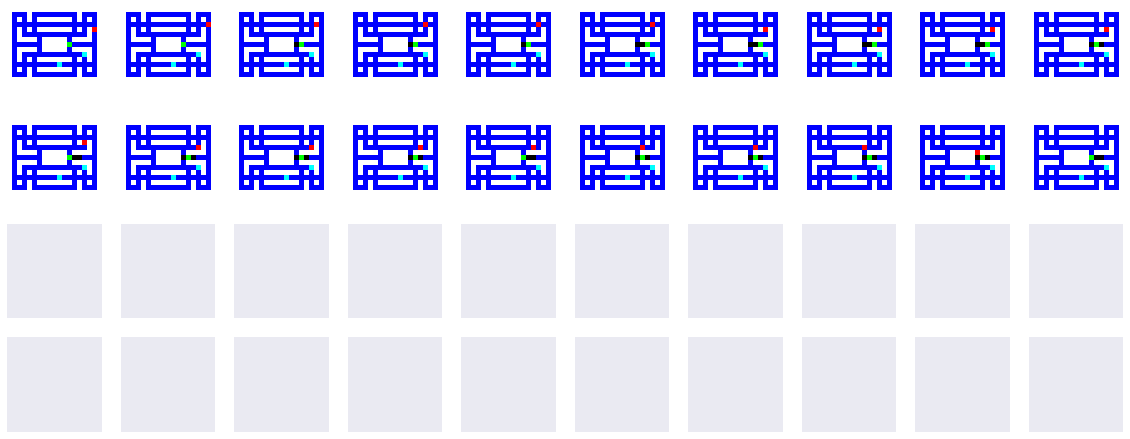

In [12]:
def run():
  tf.reset_default_graph()

  num_actions = 5
  rollout_depth = 3
  output_size = 128
  height = 15
  width = 19
  rgb = 3
  frame_cap = 39
  learning_rate = 1e-5
  stack_size = 4
  env_model_type = CopyModel

  # Model free path
  model_free_path = FrameProcessing(output_size)
  # Imagination path
  if env_model_type == CopyModel:
    env_model = CopyModel(num_reward_bins=3)
  elif env_model_type == SizePreservingConvNetModel:
    env_model = SizePreservingConvNetModel(num_actions=num_actions,
                                           reward_bins=(-1., 0., 1.))
  rollout_policy = RolloutPolicy(num_actions, 128)
  single_imag_feature = SingleImagFeature(output_size, num_actions)
  imag_path = ImagPath(
      num_actions, rollout_depth,
      env_model, rollout_policy, single_imag_feature)
  # The I2A agent
  i2a_agent = I2AAgent(num_actions, model_free_path, imag_path,
                       height=height, width=width, stack_size=stack_size)

  input_frame = tf.placeholder(
      shape=(height, width, rgb), dtype=tf.float32, name='input_frame')
  # We connect the agent to the initial state. We can override this by using
  # a feed_dict with agent_state as key at session runtime.
  agent_state = i2a_agent.initial_state()
  (action, policy_logits, baseline), agent_next_state = i2a_agent(input_frame,
                                                                  agent_state)
  # The environment
  env = PillEater(mode='regular', frame_cap=frame_cap)
  env.start()

  # Distillation loss. Sonnet handles weight sharing naturally, so we can simply
  # apply the rollout_policy on the frames.
  _, rollout_logits = rollout_policy(tf.expand_dims(input_frame, axis=0))
  distill_loss = tf.nn.softmax_cross_entropy_with_logits(
      logits=rollout_logits,
      labels=tf.stop_gradient(tf.nn.softmax(policy_logits)))
  optim_step = tf.train.RMSPropOptimizer(
      learning_rate=learning_rate, epsilon=0.1).minimize(distill_loss)

  # Run until termination of an episode, and display all observed frames.
  init_global = tf.global_variables_initializer()
  tf.get_default_graph().finalize()
  with tf.Session() as sess:
    sess.run(init_global)

    env_pcontinue = 1.
    num_frames = frame_cap + 1
    num_horiz = 10
    num_vert = (num_frames + num_horiz - 1) // num_horiz
    fig, axes_grid = plt.subplots(num_vert, num_horiz)
    fig.set_figwidth(2 * num_horiz)
    fig.set_figheight(2 * num_vert)
    axes = []
    for ax in axes_grid:
      axes.extend(ax)
    for axis in axes:
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
    step_count = 0
    total_reward = 0.
    prev_state = None
    while env_pcontinue == 1.:
      env_reward, env_pcontinue, env_frame = env.observation()
      total_reward += env_reward
      feed_dict = {input_frame: env_frame}
      if prev_state is not None:
        feed_dict[agent_state] = prev_state
      action_out, _, prev_state = sess.run([action, optim_step, agent_next_state],
                                             feed_dict=feed_dict)
      env.step(action_out[0, 0])
      axis = axes[step_count]
      axis.imshow(env_frame)
      step_count += 1
    print('Total reward at end of episode: {}.'.format(total_reward))

run()